In [25]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import warnings
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, log_loss
%matplotlib inline

warnings.filterwarnings("ignore")



def feat_select(train, test):
    features = train.drop(['is_trade', 'time', 'context_timestamp'], axis=1).columns.tolist()
    feature = []
    target = ['is_trade']

    return features, target

def logloss(act, pred):
  epsilon = 1e-15
  pred = sp.maximum(epsilon, pred)
  pred = sp.minimum(1-epsilon, pred)
  ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
  ll = ll * -1.0/len(act)
  return ll

def lgb_model():

    print('LGBMClassifier...')
    lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=48, max_depth=-1, learning_rate=0.05, n_estimators=2000,
                               max_bin=425, subsample_for_bin=50000, objective='binary', min_split_gain=0,
                               min_child_weight=5, min_child_samples=10, subsample=1, subsample_freq=1,
                               colsample_bytree=1, reg_alpha=3, reg_lambda=5, seed=1000, nthread=-1, silent=True)
    return lgb_clf

def lgbCV(train, test):
    features, target = feat_select(train, test)
    
    lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=48, max_depth=-1, learning_rate=0.05, n_estimators=2000,
                               max_bin=425, subsample_for_bin=50000, objective='binary', min_split_gain=0,
                               min_child_weight=5, min_child_samples=10, subsample=1, subsample_freq=1,
                               colsample_bytree=1, reg_alpha=3, reg_lambda=5, seed=1000, nthread=-1, silent=True)

    lgb_model = lgb_clf.fit(train[features], train[target], eval_set=[(test[features], test[target])], early_stopping_rounds=200)
    best_iter = lgb_model.best_iteration_ 
    
    # 特征重要性
    lgb_predictors = [i for i in train[features].columns]
    lgb_feat_imp = pd.Series(lgb_model.feature_importances_, lgb_predictors).sort_values(ascending=False)
    lgb_feat_imp.to_csv('lgb_feat_imp.csv')
    
    # 训练模型
#     lgb_clf.fit(train[features], train[target])
    test['lgb_predict'] = lgb_clf.predict_proba(test[features])[:, 1]
    lgb_loss = log_loss(test[target], test['lgb_predict'])  
    lgb_auc = metrics.roc_auc_score(test[target], test['lgb_predict'])
    print('Training loss: %.6f, Training AUC: %.6f' % (lgb_loss, lgb_auc))
    
    return best_iter,lgb_loss

def sub(train, test, best_iter):

    features, target = feat_select(train, test)
    
    lgb_clf = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=48, max_depth=-1, learning_rate=0.05, n_estimators=best_iter,
                               max_bin=425, subsample_for_bin=50000, objective='binary', min_split_gain=0,
                               min_child_weight=5, min_child_samples=10, subsample=1, subsample_freq=1,
                               colsample_bytree=1, reg_alpha=3, reg_lambda=5, seed=1000, nthread=-1, silent=True)

    lgb_clf = lgb_model()
    
    lgb_clf.fit(train[features], train[target])
    y_pred=lgb_clf.predict(test[features])
    return lgb_clf,y_pred

In [9]:
path = './data/'
data = pd.read_csv(path + 'all_final_data_11-07-18-51.csv')
data = data[data.is_trade.notnull()]
train_data, test_data = train_test_split(data, test_size=0.25)

In [23]:
best_iter,lgb_loss = lgbCV(train_data, test_data)
print('最佳迭代次数：', best_iter)

[1]	valid_0's binary_logloss: 0.0946925
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.0936191
[3]	valid_0's binary_logloss: 0.0927748
[4]	valid_0's binary_logloss: 0.0920529
[5]	valid_0's binary_logloss: 0.0914392
[6]	valid_0's binary_logloss: 0.0909186
[7]	valid_0's binary_logloss: 0.090444
[8]	valid_0's binary_logloss: 0.0900253
[9]	valid_0's binary_logloss: 0.0896722
[10]	valid_0's binary_logloss: 0.0893414
[11]	valid_0's binary_logloss: 0.0890154
[12]	valid_0's binary_logloss: 0.0887338
[13]	valid_0's binary_logloss: 0.0884764
[14]	valid_0's binary_logloss: 0.0882248
[15]	valid_0's binary_logloss: 0.0880022
[16]	valid_0's binary_logloss: 0.08782
[17]	valid_0's binary_logloss: 0.0876137
[18]	valid_0's binary_logloss: 0.0874331
[19]	valid_0's binary_logloss: 0.0872833
[20]	valid_0's binary_logloss: 0.087134
[21]	valid_0's binary_logloss: 0.086998
[22]	valid_0's binary_logloss: 0.0868532
[23]	valid_0's binary_logloss: 0.0867157
[24]	val

[197]	valid_0's binary_logloss: 0.0834337
[198]	valid_0's binary_logloss: 0.0834323
[199]	valid_0's binary_logloss: 0.0834294
[200]	valid_0's binary_logloss: 0.0834232
[201]	valid_0's binary_logloss: 0.0834215
[202]	valid_0's binary_logloss: 0.083423
[203]	valid_0's binary_logloss: 0.0834305
[204]	valid_0's binary_logloss: 0.0834315
[205]	valid_0's binary_logloss: 0.0834301
[206]	valid_0's binary_logloss: 0.0834334
[207]	valid_0's binary_logloss: 0.0834284
[208]	valid_0's binary_logloss: 0.0834244
[209]	valid_0's binary_logloss: 0.0834215
[210]	valid_0's binary_logloss: 0.083424
[211]	valid_0's binary_logloss: 0.0834249
[212]	valid_0's binary_logloss: 0.0834235
[213]	valid_0's binary_logloss: 0.0834236
[214]	valid_0's binary_logloss: 0.083415
[215]	valid_0's binary_logloss: 0.0834199
[216]	valid_0's binary_logloss: 0.0834204
[217]	valid_0's binary_logloss: 0.0834267
[218]	valid_0's binary_logloss: 0.0834291
[219]	valid_0's binary_logloss: 0.0834266
[220]	valid_0's binary_logloss: 0.083

[393]	valid_0's binary_logloss: 0.0836043
[394]	valid_0's binary_logloss: 0.0836059
[395]	valid_0's binary_logloss: 0.0836073
[396]	valid_0's binary_logloss: 0.0836107
[397]	valid_0's binary_logloss: 0.0836139
[398]	valid_0's binary_logloss: 0.0836096
[399]	valid_0's binary_logloss: 0.083613
[400]	valid_0's binary_logloss: 0.0836172
[401]	valid_0's binary_logloss: 0.0836218
[402]	valid_0's binary_logloss: 0.0836199
[403]	valid_0's binary_logloss: 0.0836245
[404]	valid_0's binary_logloss: 0.0836264
[405]	valid_0's binary_logloss: 0.083627
[406]	valid_0's binary_logloss: 0.0836241
[407]	valid_0's binary_logloss: 0.0836209
[408]	valid_0's binary_logloss: 0.0836296
[409]	valid_0's binary_logloss: 0.0836286
[410]	valid_0's binary_logloss: 0.0836255
[411]	valid_0's binary_logloss: 0.0836261
[412]	valid_0's binary_logloss: 0.0836332
[413]	valid_0's binary_logloss: 0.0836337
[414]	valid_0's binary_logloss: 0.0836313
Early stopping, best iteration is:
[214]	valid_0's binary_logloss: 0.083415
Tr

In [26]:
lgb_clf,y_pred=sub(train_data, test_data, best_iter)

LGBMClassifier...


In [28]:
features, target = feat_select(train_data, test_data)
y_true= test_data[target].values

In [29]:
y_true.shape

(119754, 1)

In [32]:
predictions = [round(value) for value in y_pred]
predictions=np.array(predictions).T
predictions.shape

(119754,)

In [33]:
#输出模型的一些结果
print ("\n关于现在这个模型")
print ("准确率 : %.4g" % metrics.accuracy_score(y_true, predictions))
print("召回率:%.4f" % metrics.recall_score(y_true,predictions))
print("F1:%.4f" % metrics.f1_score(y_true, predictions))
print ("AUC 得分 (训练集): %f" % 0.894629)
print ("AUC 得分 (测试集): %f" % 0.767525)


关于现在这个模型
准确率 : 0.9815
召回率:0.0559
F1:0.1057
AUC 得分 (训练集): 0.894629
AUC 得分 (测试集): 0.767525


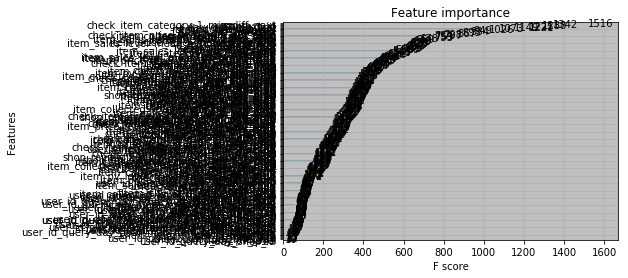

In [76]:
xgb.plot_importance(gbm)

In [84]:
importance = gbm.get_fscore()
for key,value in importance.items():
    print(key,value)

u_day_diffTime_last 949
user_id_query_day_hour_item_id 251
item_price_level_mean_by_category 248
item_price_level_user_age_prob 355
brand_mean_hour 400
instance_id 1026
context_id 1342
shop_score_delivery 1221
item_pv_level_shop_rev_prob 339
user_id 1073
check_item_category_1_min_diff_next 1516
item_price_level_mean_by_brand 649
item_sales_level_mean_by_city_ratio 753
item_sales_level_mean_by_category_ratio 630
item_sales_level_user_age_prob 335
item_brand_id 476
check_item_id_min_diff_last 173
mean_item_price_level 753
item_brand_id_shop_rev_prob 319
item_pv_level_mean_by_city_ratio 232
check_item_price_level_min_diff_next 867
b_day_diffTime_first 432
check_item_brand_id_min_diff_last 207
item_id_lasttime_diff 1149
click_user_item_lab 516
item_price_level_user_gender_prob 95
i_day_diffTime_first 1288
item_id_user_prob 378
check_item_sales_level_min_diff_next 247
item_sales_level_mean_by_brand 362
shop_mean_age 640
item_sales_level_user_gender_prob 141
i_day_diffTime_last 1225
item_col